In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [2]:
def filter_images_by_landscape(images):
    output = []
    
    for img in tqdm(images, total=len(images)):
        x = cv2.imread(img, cv2.IMREAD_COLOR)
        
        h, w, c = x.shape
        if w > h:
            output.append(img)
            
    return output

In [3]:
def filter_images_by_size(images, min_size=768):
    output = []
    
    for img in tqdm(images, total=len(images)):
        x = cv2.imread(img, cv2.IMREAD_COLOR)
        
        h, w, c = x.shape
        if h > min_size and w > min_size:
            output.append(img)
    
    return output

In [4]:
paths = glob("train/adenocarcinoma/*.png")

# Read each image
images = [cv2.imread(path, cv2.IMREAD_COLOR) for path in paths]

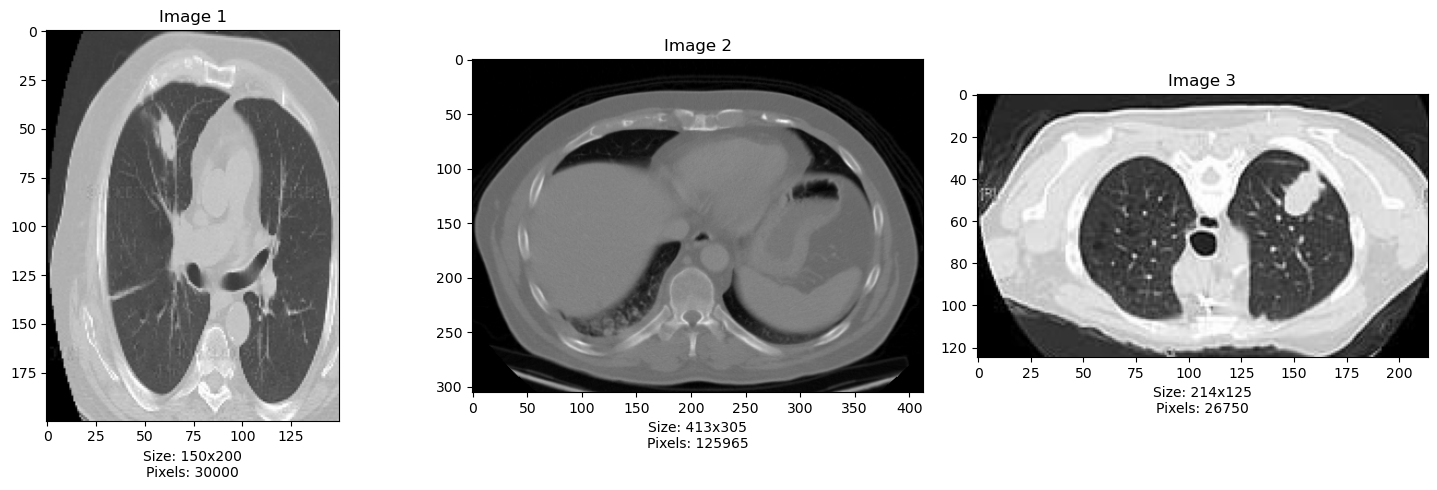

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, ax in enumerate(axes):
    # Display image
    ax.imshow(cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB))
    ax.set_title(f"Image {i + 1}")

    # Display size and pixels information
    height, width, _ = images[i].shape
    pixels = height * width
    ax.set_xlabel(f"Size: {width}x{height}\nPixels: {pixels}")

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [10]:
def save_images(images, save_dir, size=(200, 150)):
    idx = 1

    for path in tqdm(images, total=len(images)):
        x = cv2.imread(path, cv2.IMREAD_COLOR)

        scale = 20
        h = int(x.shape[0] * scale / 100)
        w = int(x.shape[1] * scale / 100)
        x = cv2.resize(x, (h,w))

        if x.shape[0] > size[0] and x.shape[1] > size[1]:
            x = x[0:size[0], 0:size[1], :]

            cv2.imwrite(f"{save_dir}\\{idx}.png", x)
            idx += 1

In [11]:
import os

def rename_files_in_folder(folder_path):
    files = os.listdir(folder_path)
    files.sort()
    for i, file_name in enumerate(files, start=1):
        current_path = os.path.join(folder_path, file_name)
        new_name = f"{i}.png"
        new_path = os.path.join(folder_path, new_name)
        os.rename(current_path, new_path)

In [ ]:
folder_path = "valid/adenocarcinoma"
rename_files_in_folder(folder_path)

### Making Masks

In [16]:
import numpy as np
import cv2
import json

In [4]:
f = open("train/annotate.json","r")
data = json.load(f)
print(data)

{'info': {'description': 'my-project-name'}, 'images': [{'id': 1, 'width': 150, 'height': 200, 'file_name': '1.png'}, {'id': 2, 'width': 413, 'height': 305, 'file_name': '10.png'}, {'id': 3, 'width': 214, 'height': 125, 'file_name': '100.png'}, {'id': 4, 'width': 172, 'height': 110, 'file_name': '101.png'}, {'id': 5, 'width': 418, 'height': 267, 'file_name': '11.png'}, {'id': 6, 'width': 416, 'height': 278, 'file_name': '12.png'}, {'id': 7, 'width': 449, 'height': 310, 'file_name': '13.png'}, {'id': 8, 'width': 369, 'height': 309, 'file_name': '14.png'}, {'id': 9, 'width': 429, 'height': 245, 'file_name': '15.png'}, {'id': 10, 'width': 393, 'height': 269, 'file_name': '16.png'}, {'id': 11, 'width': 409, 'height': 224, 'file_name': '17.png'}, {'id': 12, 'width': 385, 'height': 263, 'file_name': '18.png'}, {'id': 13, 'width': 368, 'height': 249, 'file_name': '19.png'}, {'id': 14, 'width': 150, 'height': 200, 'file_name': '2.png'}, {'id': 15, 'width': 419, 'height': 285, 'file_name': '20.

In [5]:
images = data["images"]
annots = data["annotations"]

In [6]:
print(images)
print("kkkkkk                            kkkkkkkkkkkkkkkkk")
print(annots)

[{'id': 1, 'width': 150, 'height': 200, 'file_name': '1.png'}, {'id': 2, 'width': 413, 'height': 305, 'file_name': '10.png'}, {'id': 3, 'width': 214, 'height': 125, 'file_name': '100.png'}, {'id': 4, 'width': 172, 'height': 110, 'file_name': '101.png'}, {'id': 5, 'width': 418, 'height': 267, 'file_name': '11.png'}, {'id': 6, 'width': 416, 'height': 278, 'file_name': '12.png'}, {'id': 7, 'width': 449, 'height': 310, 'file_name': '13.png'}, {'id': 8, 'width': 369, 'height': 309, 'file_name': '14.png'}, {'id': 9, 'width': 429, 'height': 245, 'file_name': '15.png'}, {'id': 10, 'width': 393, 'height': 269, 'file_name': '16.png'}, {'id': 11, 'width': 409, 'height': 224, 'file_name': '17.png'}, {'id': 12, 'width': 385, 'height': 263, 'file_name': '18.png'}, {'id': 13, 'width': 368, 'height': 249, 'file_name': '19.png'}, {'id': 14, 'width': 150, 'height': 200, 'file_name': '2.png'}, {'id': 15, 'width': 419, 'height': 285, 'file_name': '20.png'}, {'id': 16, 'width': 420, 'height': 243, 'file_na

In [9]:
mask_dir = "train/mask"

In [10]:
import numpy as np
import cv2

for x, y in zip(images, annots):
    filename = x["file_name"]
    h = x["height"]
    w = x["width"]
    
    mask = np.zeros((h, w), dtype=np.uint8)  # Specify the data type as np.uint8 for the mask.
    
    seg = y["segmentation"]
    
    for points in seg:
        contour = []
        
        for i in range(0, len(points), 2):
            contour.append((points[i], points[i + 1]))
            
        contours = np.array(contour, dtype=np.int32)
        
        cv2.drawContours(mask, [contours], -1, 255, thickness=cv2.FILLED)  # Use thickness=cv2.FILLED to fill the contour.
    
    cv2.imwrite(f"{mask_dir}/{filename}", mask)  # Use / instead of \\ in the path.


### Data Processing

In [13]:
import os
import numpy as np
import cv2
from glob import glob
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [14]:
def load_dataset(path):
    images = sorted(glob(os.path.join(path,"adenocarcinoma", "*")))
    
    return images

In [14]:
import os
import glob

# Folder path
folder_path = 'train/mask/'

# Use os.path.join to join folder path with wildcard
images_path = os.path.join(folder_path, '*')

# Use glob.glob to get all files matching the path
mask = glob.glob(images_path)

print(mask)

['train/mask\\1.png', 'train/mask\\10.png', 'train/mask\\100.png', 'train/mask\\101.png', 'train/mask\\11.png', 'train/mask\\12.png', 'train/mask\\13.png', 'train/mask\\14.png', 'train/mask\\15.png', 'train/mask\\16.png', 'train/mask\\17.png', 'train/mask\\18.png', 'train/mask\\19.png', 'train/mask\\2.png', 'train/mask\\20.png', 'train/mask\\21.png', 'train/mask\\22.png', 'train/mask\\23.png', 'train/mask\\24.png', 'train/mask\\25.png', 'train/mask\\26.png', 'train/mask\\27.png', 'train/mask\\28.png', 'train/mask\\29.png', 'train/mask\\3.png', 'train/mask\\30.png', 'train/mask\\31.png', 'train/mask\\32.png', 'train/mask\\33.png', 'train/mask\\34.png', 'train/mask\\35.png', 'train/mask\\36.png', 'train/mask\\37.png', 'train/mask\\38.png', 'train/mask\\39.png', 'train/mask\\4.png', 'train/mask\\40.png', 'train/mask\\41.png', 'train/mask\\42.png', 'train/mask\\43.png', 'train/mask\\44.png', 'train/mask\\45.png', 'train/mask\\46.png', 'train/mask\\47.png', 'train/mask\\48.png', 'train/mask

In [15]:
import os
import glob

# Folder path
folder_path = 'train/adenocarcinoma/'

# Use os.path.join to join folder path with wildcard
images_path = os.path.join(folder_path, '*')

# Use glob.glob to get all files matching the path
images = glob.glob(images_path)

print(images)

['train/adenocarcinoma\\1.png', 'train/adenocarcinoma\\10.png', 'train/adenocarcinoma\\100.png', 'train/adenocarcinoma\\101.png', 'train/adenocarcinoma\\11.png', 'train/adenocarcinoma\\12.png', 'train/adenocarcinoma\\13.png', 'train/adenocarcinoma\\14.png', 'train/adenocarcinoma\\15.png', 'train/adenocarcinoma\\16.png', 'train/adenocarcinoma\\17.png', 'train/adenocarcinoma\\18.png', 'train/adenocarcinoma\\19.png', 'train/adenocarcinoma\\2.png', 'train/adenocarcinoma\\20.png', 'train/adenocarcinoma\\21.png', 'train/adenocarcinoma\\22.png', 'train/adenocarcinoma\\23.png', 'train/adenocarcinoma\\24.png', 'train/adenocarcinoma\\25.png', 'train/adenocarcinoma\\26.png', 'train/adenocarcinoma\\27.png', 'train/adenocarcinoma\\28.png', 'train/adenocarcinoma\\29.png', 'train/adenocarcinoma\\3.png', 'train/adenocarcinoma\\30.png', 'train/adenocarcinoma\\31.png', 'train/adenocarcinoma\\32.png', 'train/adenocarcinoma\\33.png', 'train/adenocarcinoma\\34.png', 'train/adenocarcinoma\\35.png', 'train/a

In [16]:
for x,y in zip(images,mask):
    print(x,y)

train/adenocarcinoma\1.png train/mask\1.png
train/adenocarcinoma\10.png train/mask\10.png
train/adenocarcinoma\100.png train/mask\100.png
train/adenocarcinoma\101.png train/mask\101.png
train/adenocarcinoma\11.png train/mask\11.png
train/adenocarcinoma\12.png train/mask\12.png
train/adenocarcinoma\13.png train/mask\13.png
train/adenocarcinoma\14.png train/mask\14.png
train/adenocarcinoma\15.png train/mask\15.png
train/adenocarcinoma\16.png train/mask\16.png
train/adenocarcinoma\17.png train/mask\17.png
train/adenocarcinoma\18.png train/mask\18.png
train/adenocarcinoma\19.png train/mask\19.png
train/adenocarcinoma\2.png train/mask\2.png
train/adenocarcinoma\20.png train/mask\20.png
train/adenocarcinoma\21.png train/mask\21.png
train/adenocarcinoma\22.png train/mask\22.png
train/adenocarcinoma\23.png train/mask\23.png
train/adenocarcinoma\24.png train/mask\24.png
train/adenocarcinoma\25.png train/mask\25.png
train/adenocarcinoma\26.png train/mask\26.png
train/adenocarcinoma\27.png train/

### Visualize the images and mask

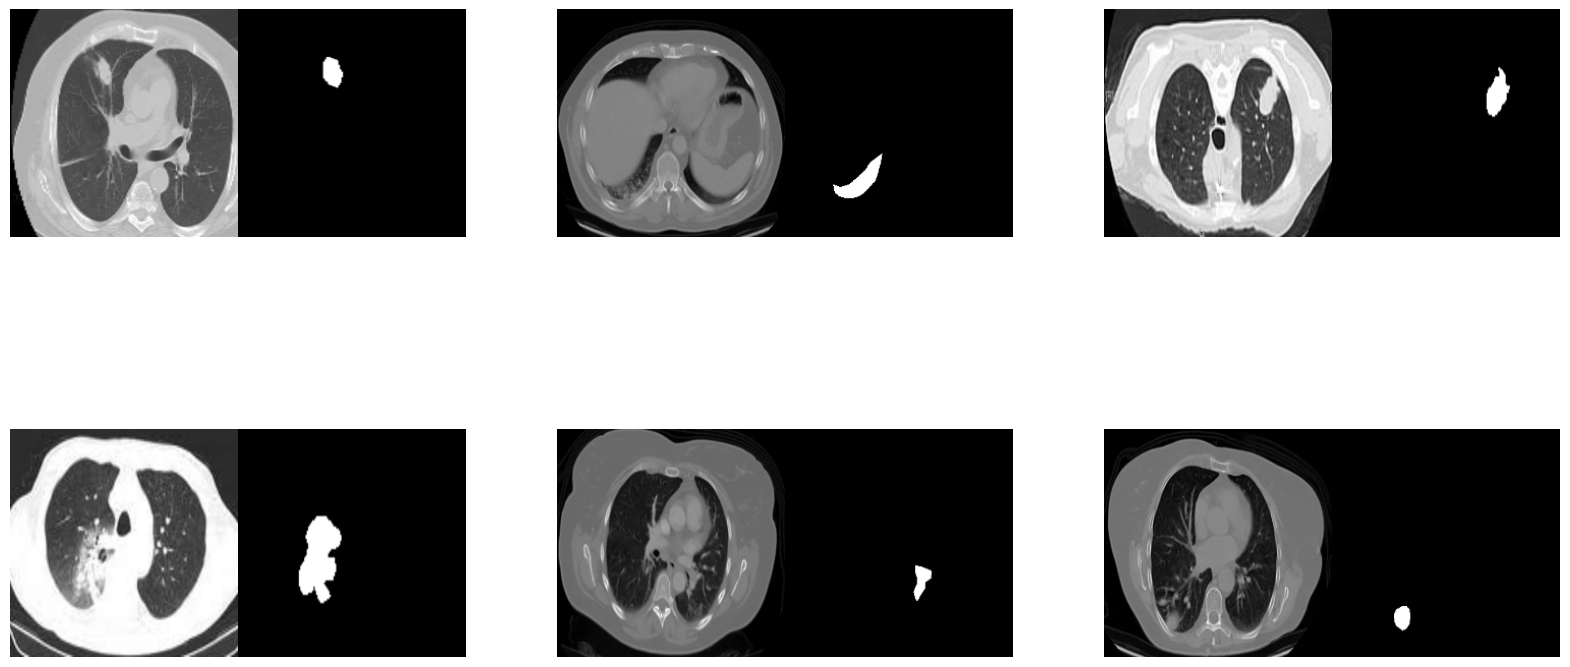

In [17]:
import cv2
from imshowtools import imshow

cat = []
for x,y in zip(images[:6], mask[:6]):

  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255.0
  x = cv2.resize(x, (224,224))
  
  y = cv2.imread(y, cv2.IMREAD_COLOR)/255.0
  y = cv2.resize(y, (224,224))  

  z = np.concatenate([x,y], axis=1)
  cat.append(z)

imshow(*cat, size=(20,10), columns=3)

### Testing Image Preprocessing

In [17]:
f = open("test/mask_test.json","r")
data = json.load(f)
print(data)

{'info': {'description': 'my-project-name'}, 'images': [{'id': 1, 'width': 482, 'height': 333, 'file_name': '1.png'}, {'id': 2, 'width': 424, 'height': 357, 'file_name': '10.png'}, {'id': 3, 'width': 471, 'height': 309, 'file_name': '11.png'}, {'id': 4, 'width': 475, 'height': 397, 'file_name': '12.png'}, {'id': 5, 'width': 496, 'height': 336, 'file_name': '13.png'}, {'id': 6, 'width': 460, 'height': 389, 'file_name': '14.png'}, {'id': 7, 'width': 482, 'height': 314, 'file_name': '15.png'}, {'id': 8, 'width': 401, 'height': 310, 'file_name': '16.png'}, {'id': 9, 'width': 478, 'height': 367, 'file_name': '17.png'}, {'id': 10, 'width': 471, 'height': 307, 'file_name': '18.png'}, {'id': 11, 'width': 444, 'height': 346, 'file_name': '19.png'}, {'id': 12, 'width': 476, 'height': 386, 'file_name': '2.png'}, {'id': 13, 'width': 388, 'height': 276, 'file_name': '20.png'}, {'id': 14, 'width': 506, 'height': 281, 'file_name': '21.png'}, {'id': 15, 'width': 454, 'height': 356, 'file_name': '22.pn

In [18]:
images = data["images"]
annots = data["annotations"]

In [21]:
mask_dir = "test/mask"

In [22]:
import numpy as np
import cv2

for x, y in zip(images, annots):
    filename = x["file_name"]
    h = x["height"]
    w = x["width"]
    
    mask = np.zeros((h, w), dtype=np.uint8)  # Specify the data type as np.uint8 for the mask.
    
    seg = y["segmentation"]
    
    for points in seg:
        contour = []
        
        for i in range(0, len(points), 2):
            contour.append((points[i], points[i + 1]))
            
        contours = np.array(contour, dtype=np.int32)
        
        cv2.drawContours(mask, [contours], -1, 255, thickness=cv2.FILLED)  # Use thickness=cv2.FILLED to fill the contour.
    
    cv2.imwrite(f"{mask_dir}/{filename}", mask)  # Use / instead of \\ in the path.


In [24]:
import os
import glob

# Folder path
folder_path = 'test/adenocarcinoma_test/'

# Use os.path.join to join folder path with wildcard
images_path = os.path.join(folder_path, '*')

# Use glob.glob to get all files matching the path
images = glob.glob(images_path)

print(images)

['test/adenocarcinoma_test\\1.png', 'test/adenocarcinoma_test\\10.png', 'test/adenocarcinoma_test\\11.png', 'test/adenocarcinoma_test\\12.png', 'test/adenocarcinoma_test\\13.png', 'test/adenocarcinoma_test\\14.png', 'test/adenocarcinoma_test\\15.png', 'test/adenocarcinoma_test\\16.png', 'test/adenocarcinoma_test\\17.png', 'test/adenocarcinoma_test\\18.png', 'test/adenocarcinoma_test\\19.png', 'test/adenocarcinoma_test\\2.png', 'test/adenocarcinoma_test\\20.png', 'test/adenocarcinoma_test\\21.png', 'test/adenocarcinoma_test\\22.png', 'test/adenocarcinoma_test\\23.png', 'test/adenocarcinoma_test\\24.png', 'test/adenocarcinoma_test\\25.png', 'test/adenocarcinoma_test\\26.png', 'test/adenocarcinoma_test\\27.png', 'test/adenocarcinoma_test\\28.png', 'test/adenocarcinoma_test\\29.png', 'test/adenocarcinoma_test\\3.png', 'test/adenocarcinoma_test\\30.png', 'test/adenocarcinoma_test\\31.png', 'test/adenocarcinoma_test\\32.png', 'test/adenocarcinoma_test\\33.png', 'test/adenocarcinoma_test\\34.

In [30]:
import os
import glob

# Folder path
folder_path = 'test/mask/'

# Use os.path.join to join folder path with wildcard
images_path = os.path.join(folder_path, '*')

# Use glob.glob to get all files matching the path
mask = glob.glob(images_path)

print(mask)

['test/mask\\1.png', 'test/mask\\10.png', 'test/mask\\11.png', 'test/mask\\12.png', 'test/mask\\13.png', 'test/mask\\14.png', 'test/mask\\15.png', 'test/mask\\16.png', 'test/mask\\17.png', 'test/mask\\18.png', 'test/mask\\19.png', 'test/mask\\2.png', 'test/mask\\20.png', 'test/mask\\21.png', 'test/mask\\22.png', 'test/mask\\23.png', 'test/mask\\24.png', 'test/mask\\25.png', 'test/mask\\26.png', 'test/mask\\27.png', 'test/mask\\28.png', 'test/mask\\29.png', 'test/mask\\3.png', 'test/mask\\30.png', 'test/mask\\31.png', 'test/mask\\32.png', 'test/mask\\33.png', 'test/mask\\34.png', 'test/mask\\35.png', 'test/mask\\36.png', 'test/mask\\37.png', 'test/mask\\38.png', 'test/mask\\39.png', 'test/mask\\4.png', 'test/mask\\40.png', 'test/mask\\41.png', 'test/mask\\42.png', 'test/mask\\43.png', 'test/mask\\44.png', 'test/mask\\45.png', 'test/mask\\46.png', 'test/mask\\47.png', 'test/mask\\48.png', 'test/mask\\49.png', 'test/mask\\5.png', 'test/mask\\50.png', 'test/mask\\51.png', 'test/mask\\52.pn

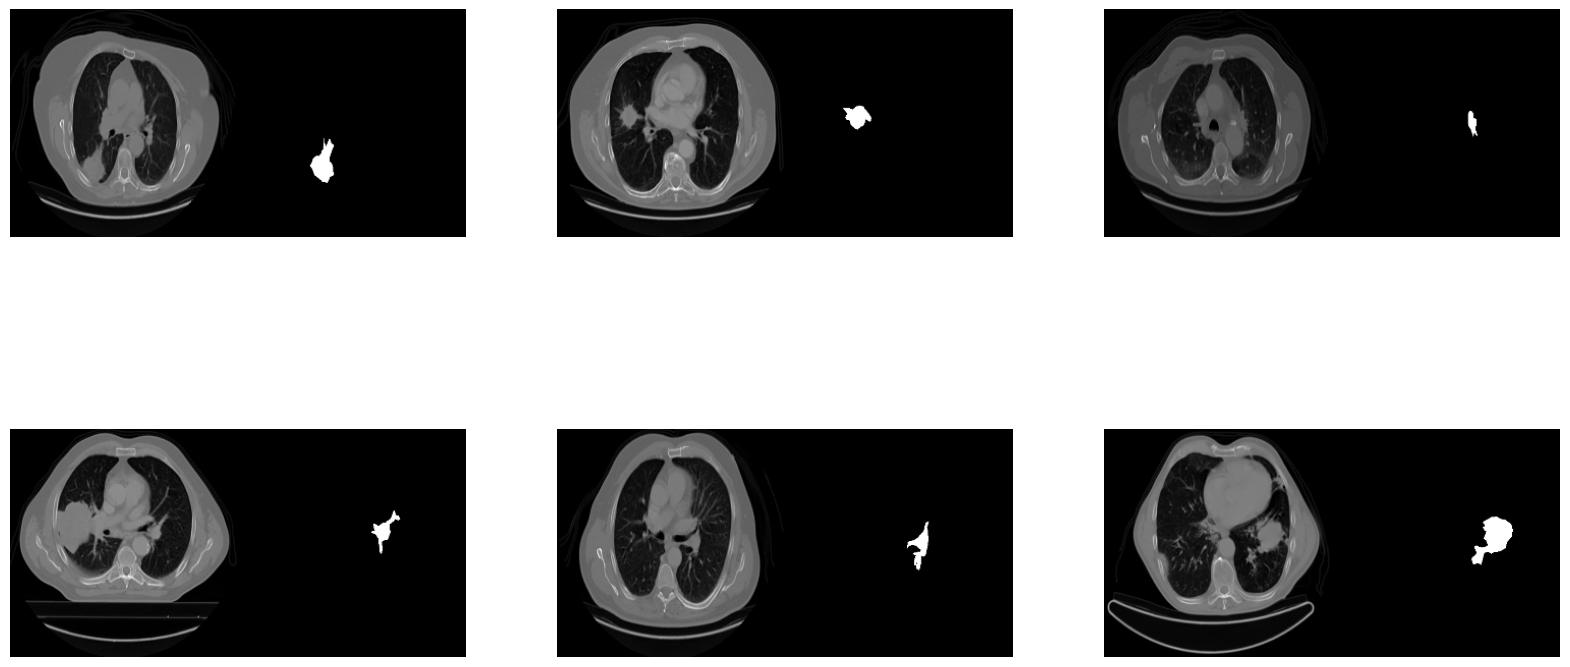

In [31]:
import cv2
from imshowtools import imshow

cat = []
for x,y in zip(images[:6], mask[:6]):

  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255.0
  x = cv2.resize(x, (224,224))
  
  y = cv2.imread(y, cv2.IMREAD_COLOR)/255.0
  y = cv2.resize(y, (224,224))  

  z = np.concatenate([x,y], axis=1)
  cat.append(z)

imshow(*cat, size=(20,10), columns=3)

### Valid Masking

In [42]:
f = open("valid/mask_valid.json","r")
data = json.load(f)
print(data)

{'info': {'description': 'my-project-name'}, 'images': [{'id': 1, 'width': 315, 'height': 245, 'file_name': '1.png'}, {'id': 2, 'width': 431, 'height': 245, 'file_name': '10.png'}, {'id': 3, 'width': 358, 'height': 253, 'file_name': '11.png'}, {'id': 4, 'width': 361, 'height': 202, 'file_name': '12.png'}, {'id': 5, 'width': 359, 'height': 252, 'file_name': '13.png'}, {'id': 6, 'width': 356, 'height': 258, 'file_name': '14.png'}, {'id': 7, 'width': 421, 'height': 246, 'file_name': '15.png'}, {'id': 8, 'width': 379, 'height': 299, 'file_name': '16.png'}, {'id': 9, 'width': 409, 'height': 274, 'file_name': '17.png'}, {'id': 10, 'width': 388, 'height': 235, 'file_name': '18.png'}, {'id': 11, 'width': 395, 'height': 247, 'file_name': '2.png'}, {'id': 12, 'width': 439, 'height': 264, 'file_name': '3.png'}, {'id': 13, 'width': 424, 'height': 335, 'file_name': '4.png'}, {'id': 14, 'width': 406, 'height': 256, 'file_name': '5.png'}, {'id': 15, 'width': 381, 'height': 219, 'file_name': '6.png'},

In [43]:
images = data["images"]
annots = data["annotations"]

In [44]:
mask_dir = "valid/mask"

In [45]:
import numpy as np
import cv2

for x, y in zip(images, annots):
    filename = x["file_name"]
    h = x["height"]
    w = x["width"]
    
    mask = np.zeros((h, w), dtype=np.uint8)
    
    seg = y["segmentation"]
    
    for points in seg:
        contour = []
        
        for i in range(0, len(points), 2):
            contour.append((points[i], points[i + 1]))
            
        contours = np.array(contour, dtype=np.int32)
        
        cv2.drawContours(mask, [contours], -1, 255, thickness=cv2.FILLED)
    
    cv2.imwrite(f"{mask_dir}/{filename}", mask)


In [46]:
import os
import glob

# Folder path
folder_path = 'valid/adenocarcinoma/'

# Use os.path.join to join folder path with wildcard
images_path = os.path.join(folder_path, '*')

# Use glob.glob to get all files matching the path
images = glob.glob(images_path)

print(images)

['valid/adenocarcinoma\\1.png', 'valid/adenocarcinoma\\10.png', 'valid/adenocarcinoma\\11.png', 'valid/adenocarcinoma\\12.png', 'valid/adenocarcinoma\\13.png', 'valid/adenocarcinoma\\14.png', 'valid/adenocarcinoma\\15.png', 'valid/adenocarcinoma\\16.png', 'valid/adenocarcinoma\\17.png', 'valid/adenocarcinoma\\18.png', 'valid/adenocarcinoma\\2.png', 'valid/adenocarcinoma\\3.png', 'valid/adenocarcinoma\\4.png', 'valid/adenocarcinoma\\5.png', 'valid/adenocarcinoma\\6.png', 'valid/adenocarcinoma\\7.png', 'valid/adenocarcinoma\\8.png', 'valid/adenocarcinoma\\9.png']


In [47]:
import os
import glob

# Folder path
folder_path = 'valid/mask/'

# Use os.path.join to join folder path with wildcard
images_path = os.path.join(folder_path, '*')

# Use glob.glob to get all files matching the path
mask = glob.glob(images_path)

print(mask)

['valid/mask\\1.png', 'valid/mask\\10.png', 'valid/mask\\11.png', 'valid/mask\\12.png', 'valid/mask\\13.png', 'valid/mask\\14.png', 'valid/mask\\15.png', 'valid/mask\\16.png', 'valid/mask\\17.png', 'valid/mask\\18.png', 'valid/mask\\2.png', 'valid/mask\\3.png', 'valid/mask\\4.png', 'valid/mask\\5.png', 'valid/mask\\6.png', 'valid/mask\\7.png', 'valid/mask\\8.png', 'valid/mask\\9.png']


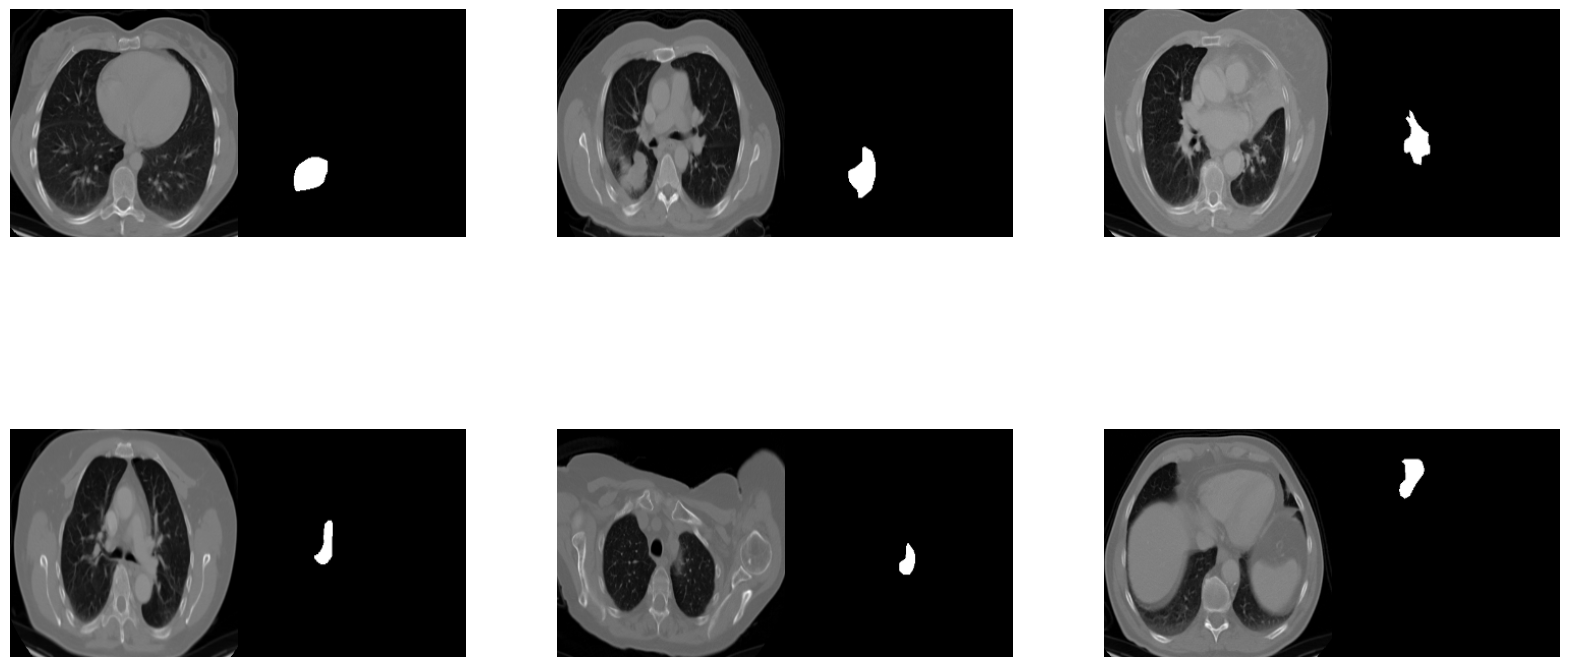

In [48]:
import cv2
from imshowtools import imshow

cat = []
for x,y in zip(images[:6], mask[:6]):

  x = cv2.imread(x, cv2.IMREAD_COLOR)
  x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255.0
  x = cv2.resize(x, (224,224))
  
  y = cv2.imread(y, cv2.IMREAD_COLOR)/255.0
  y = cv2.resize(y, (224,224))  

  z = np.concatenate([x,y], axis=1)
  cat.append(z)

imshow(*cat, size=(20,10), columns=3)